# Mantis Shrimp Timestamping DEMO

### First, we have a raw video and then it is fed through tracktor, which spits out a csv file

#### This script contains a function that will take in a dataframe of a tracked video and generate all of the distance dataframes for the different combos of shrimp


In [23]:
import numpy as np  
import pandas as pd
import tracktor as tr
import seaborn as sns
import plotly.express as px
import cv2
import sys
import glob
import os
import matplotlib.pyplot as plt
import PySimpleGUI as sg
import csv
from sklearn.cluster import KMeans
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
from itertools import combinations

#### Access the function below!

In [24]:
# First, we read in our data

shrimp_df_0308 = pd.read_csv("/Users/lukefields/Desktop/Shrimp-Capstone/test_0308/BlackWhiteResult0308_tracked.csv")
shrimp_df_0308

,Unnamed: 0,frame,pos_x,pos_y,id
0,0,3.0,37.0,59.0,A
1,1,3.0,76.0,55.0,B
2,2,4.0,34.0,58.0,A
3,3,4.0,76.0,55.0,B
4,4,5.0,35.0,58.0,A
...,...,...,...,...,...
3257,3257,1631.0,61.0,56.0,B
3258,3258,1632.0,30.0,57.0,A
3259,3259,1632.0,56.0,59.0,B
3260,3260,1633.0,31.0,57.0,A


In [25]:
# output_filepath = '/Users/lukefields/Desktop/Shrimp-Capstone/tracktor-master/videos/' + video + '_tracked.csv'
# Output filepath will be something like the template below
# "/Users/yourname/Desktop/shripfolder/where-ever-it-is-you-want-your-output/" + shrimp1 + shrimp2 + "_distances.csv"
# Or a realized version, Luke Fields's specific file path for where he wants the output
# "/Users/lukefields/Desktop/Shrimp-Capstone/tracktor-master/output/zebrafish_video_tracked.csv"

# Label will be a string of what you want to uniquely identify this file as
# For example, if you were working with shrimp from April 3, perhaps you would input "0403" for label
# Another example, if you were working with shrimp for a certain researcher, perhaps you would input their name

def get_distances(dataframe, output_filepath, label, fps):
    diff_ids = dataframe["id"].unique()
    shrimp_combo = []
    for combo in combinations(diff_ids, 2):  # 2 for pairs, 3 for triplets, etc
        shrimp_combo.append(combo)
    
    for pair in shrimp_combo:
        shrimpX = pair[0]
        shrimpY = pair[1]

        # This will subset our dataframe into one with just the two animals we care about
        dataframe2 = dataframe[(dataframe["id"] == shrimpX) | (dataframe["id"] == shrimpY)]

        for idx, ID in enumerate(np.unique(dataframe2['id'])):
                dataframe2['id'][dataframe2['id'] == ID] = idx
                #print(dataframe.shape)
        distances = []
        for fr in np.unique(dataframe['frame']):
                tmp = dataframe2[dataframe2['frame'] == fr]
                x = tmp[tmp['id'] == 0]['pos_x'].values[0] - tmp[tmp['id'] == 1]['pos_x'].values[0]
                y = tmp[tmp['id'] == 0]['pos_y'].values[0] - tmp[tmp['id'] == 1]['pos_y'].values[0]
                distances.append(np.sqrt(x**2 + y**2))

        timestamp = np.unique(dataframe2['frame'])/fps
        
        def convert_time(seconds):
            seconds = seconds % (24 * 3600)
            hour = seconds // 3600
            seconds %= 3600
            minutes = seconds // 60
            seconds %= 60     
            milliseconds = (seconds % 1) * 100
            milliseconds
            return "%d:%02d:%02d:%2d" % (hour, minutes, seconds, milliseconds)
        
        convert_time = np.vectorize(convert_time)
        timestamp = convert_time(timestamp)
        
        frames = np.unique(dataframe2['frame'])
        
        pair_list = []
        for i in range(len(distances)):
                pair_list.append(pair)

        dist_df = pd.DataFrame([pair_list, frames, timestamp, distances]).transpose()
        dist_df.columns = ["Pair", "Frame", "Timestamp", "Distance"]

        shrimpX_str = str(shrimpX)
        shrimpY_str = str(shrimpY)

        new_output_filepath = output_filepath + shrimpX_str + shrimpY_str + "_" + label + "_distances.csv"

        dist_df.to_csv(new_output_filepath, sep=',')

In [26]:
# To not have pesky warnings
pd.options.mode.chained_assignment = None

test_output = "/Users/lukefields/Desktop/Shrimp-Capstone/test_0308/"

get_distances(shrimp_df_0308, test_output, "0308", 60)

#### To access just one dataframe and perform manipulations on it, we do the following

In [27]:
# Then, read in the "timestamped" CSV file from whatever directory 

shrimp_df_0308 = pd.read_csv('/Users/lukefields/Desktop/Shrimp-Capstone/test_0308/AB_0308_distances.csv')
shrimp_df_0308 = shrimp_df_0308.drop(["Unnamed: 0"], axis = 1)

In [28]:
shrimp_df_0308

,Pair,Frame,Timestamp,Distance
0,"('A', 'B')",3.0,0:00:00: 5,39.204592
1,"('A', 'B')",4.0,0:00:00: 6,42.107007
2,"('A', 'B')",5.0,0:00:00: 8,38.013156
3,"('A', 'B')",6.0,0:00:00:10,41.048752
4,"('A', 'B')",7.0,0:00:00:11,40.112342
...,...,...,...,...
1626,"('A', 'B')",1629.0,0:00:27:14,24.186773
1627,"('A', 'B')",1630.0,0:00:27:16,29.154759
1628,"('A', 'B')",1631.0,0:00:27:18,29.068884
1629,"('A', 'B')",1632.0,0:00:27:19,26.076810


#### The automated function to graph distances

##### Matplotlib, Ole reliable but a little boring

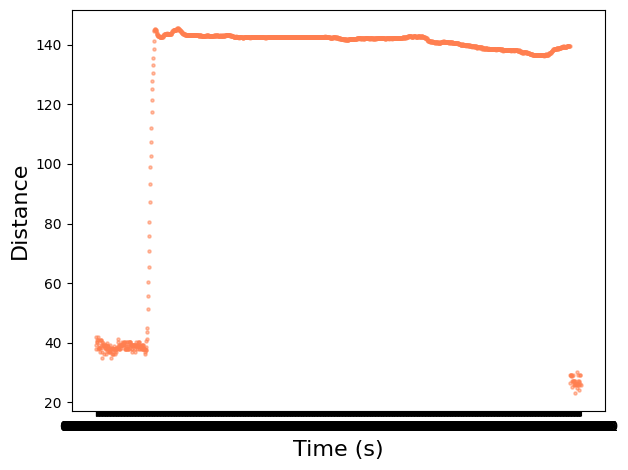

In [29]:
def graph_dist(df_dist):
    plt.scatter(df_dist["Timestamp"], df_dist["Distance"], c='#FF7F50', s=5, alpha=0.5)
    plt.xlabel('Time (s)', fontsize=16)
    plt.ylabel('Distance', fontsize=16)
    plt.tight_layout()
    plt.show()
    
graph_dist(shrimp_df_0308)

##### Plotly, a little more advanced

In [ ]:
import plotly.express as px

def graph_dist(df_dist):
    dist_plot = px.line(df_dist, x = "Timestamp", y = "Distance")
    dist_plot.show()
    
graph_dist(shrimp_df_0308)

#### If we need to generate important frames for Brian's CNN, use the following function 

In [42]:
def important_frames(df, dist_cutoff):
    if ((df.loc[df["Distance"] < dist_cutoff]).empty == True):
        df_temp = pd.DataFrame(columns = ["Pair", "Frame", "Frame_end"],
                              index = [0])
        df_pair = df["Pair"][0]
        df_temp.loc[0] = [df_pair, 0, 0]
        return df_temp
    else:
        df["Previous"] = (df["Distance"].shift(1))

        enter_eval = "Distance <= " + str(dist_cutoff) + " and not (Previous <= " + str(dist_cutoff) + ")"
        exit_eval = "Previous <= " + str(dist_cutoff) + " and not (Distance <= " + str(dist_cutoff) + ")"
        df["Enter"] = df.eval(enter_eval).cumsum()
        df["Exit"] = df.eval(exit_eval).shift(-1).fillna(True).cumsum()

        df_temp = df.merge(df.drop_duplicates("Exit", keep = "first")[["Timestamp", "Exit"]],
                              left_on = "Enter", right_on = "Exit", how = "left", suffixes = ["", "_end"])

        df_temp = df_temp.drop_duplicates(subset = "Enter", keep = "first")[["Pair", "Frame", "Frame_end"]]
        if df["Distance"][0] < dist_cutoff == True:
            return df_temp
        else:
            df_temp = df_temp.loc[1:]
            return df_temp

#### If we need to generate important timestamps for analyzing and replaying videos easier, use the following function

In [43]:
def important_timestamps(df, dist_cutoff):
    if ((df.loc[df["Distance"] < dist_cutoff]).empty == True):
        df_temp = pd.DataFrame(columns = ["Pair", "Timestamp", "Timestamp_end"],
                              index = [0])
        df_pair = df["Pair"][0]
        df_temp.loc[0] = [df_pair, 0, 0]
        return df_temp
    else:
        df["Previous"] = (df["Distance"].shift(1))

        enter_eval = "Distance <= " + str(dist_cutoff) + " and not (Previous <= " + str(dist_cutoff) + ")"
        exit_eval = "Previous <= " + str(dist_cutoff) + " and not (Distance <= " + str(dist_cutoff) + ")"
        df["Enter"] = df.eval(enter_eval).cumsum()
        df["Exit"] = df.eval(exit_eval).shift(-1).fillna(True).cumsum()

        df_temp = df.merge(df.drop_duplicates("Exit", keep = "first")[["Timestamp", "Exit"]],
                              left_on = "Enter", right_on = "Exit", how = "left", suffixes = ["", "_end"])

        df_temp = df_temp.drop_duplicates(subset = "Enter", keep = "first")[["Pair", "Timestamp", "Timestamp_end"]]
        if df["Distance"][0] < dist_cutoff == True:
            return df_temp
        else:
            df_temp = df_temp.loc[1:]
            return df_temp

In [52]:
important_timestamps(shrimp_df_0308, 50)

,Pair,Timestamp,Timestamp_end
1594,"('A', 'B')",0:00:26:61,0:00:27:21


## The big challenge: what if there are more than two shrimp we seek to analyze?

In [33]:
# Introducing a much larger dataset with 5 different zebrafish

zebra_df = pd.read_csv('/Users/lukefields/Desktop/Shrimp-Capstone/tracktor-master/output/zebrafish_video_tracked.csv')
zebra_df = zebra_df.drop(["Unnamed: 0"], axis = 1)
zebra_df

,frame,pos_x,pos_y,id
0,3.0,783.514170,62.967611,A
1,3.0,174.192848,60.541507,B
2,3.0,303.360000,119.509630,C
3,3.0,193.814035,293.143860,D
4,3.0,226.002179,333.840959,E
...,...,...,...,...
74985,15000.0,258.306878,259.282540,A
74986,15000.0,228.713333,218.145333,B
74987,15000.0,355.438155,24.925577,C
74988,15000.0,164.821256,166.346216,D


In [16]:
# Compared to our first dataset, about 15x the amount of data :O

shrimp_df_0308

,Pair,Frame,Timestamp,Distance,Previous,Enter,Exit
0,"('A', 'B')",3.0,0:00:00: 5,39.204592,39.204592,0,0
1,"('A', 'B')",4.0,0:00:00: 6,42.107007,39.204592,0,0
2,"('A', 'B')",5.0,0:00:00: 8,38.013156,42.107007,0,0
3,"('A', 'B')",6.0,0:00:00:10,41.048752,38.013156,0,0
4,"('A', 'B')",7.0,0:00:00:11,40.112342,41.048752,0,0
...,...,...,...,...,...,...,...
1626,"('A', 'B')",1629.0,0:00:27:14,24.186773,27.000000,1,1
1627,"('A', 'B')",1630.0,0:00:27:16,29.154759,24.186773,1,1
1628,"('A', 'B')",1631.0,0:00:27:18,29.068884,29.154759,1,1
1629,"('A', 'B')",1632.0,0:00:27:19,26.076810,29.068884,1,1


### So how are we going to do this if we have a ton of different combinations of shrimp (in this case zebrafish)
#### Use same function from above for calculating distances, but this one will take a lot longer to iterate through

In [19]:
def get_distances(dataframe, output_filepath, label, fps):
    diff_ids = dataframe["id"].unique()
    shrimp_combo = []
    for combo in combinations(diff_ids, 2):  # 2 for pairs, 3 for triplets, etc
        shrimp_combo.append(combo)
    
    for pair in shrimp_combo:
        shrimpX = pair[0]
        shrimpY = pair[1]

        # This will subset our dataframe into one with just the two animals we care about
        dataframe2 = dataframe[(dataframe["id"] == shrimpX) | (dataframe["id"] == shrimpY)]

        for idx, ID in enumerate(np.unique(dataframe2['id'])):
                dataframe2['id'][dataframe2['id'] == ID] = idx
                #print(dataframe.shape)
        distances = []
        for fr in np.unique(dataframe['frame']):
                tmp = dataframe2[dataframe2['frame'] == fr]
                x = tmp[tmp['id'] == 0]['pos_x'].values[0] - tmp[tmp['id'] == 1]['pos_x'].values[0]
                y = tmp[tmp['id'] == 0]['pos_y'].values[0] - tmp[tmp['id'] == 1]['pos_y'].values[0]
                distances.append(np.sqrt(x**2 + y**2))

        timestamp = np.unique(dataframe2['frame'])/fps
        
        def convert_time(seconds):
            seconds = seconds % (24 * 3600)
            hour = seconds // 3600
            seconds %= 3600
            minutes = seconds // 60
            seconds %= 60     
            milliseconds = (seconds % 1) * 100
            milliseconds
            return "%d:%02d:%02d:%2d" % (hour, minutes, seconds, milliseconds)
        
        convert_time = np.vectorize(convert_time)
        timestamp = convert_time(timestamp)
        
        frames = np.unique(dataframe2['frame'])
        
        pair_list = []
        for i in range(len(distances)):
                pair_list.append(pair)

        dist_df = pd.DataFrame([pair_list, frames, timestamp, distances]).transpose()
        dist_df.columns = ["Pair", "Frame", "Timestamp", "Distance"]

        shrimpX_str = str(shrimpX)
        shrimpY_str = str(shrimpY)

        new_output_filepath = output_filepath + shrimpX_str + shrimpY_str + "_" + label + "_distances.csv"

        dist_df.to_csv(new_output_filepath, sep=',')

# *** LUKE'S NOTE TO SELF: DO NOT EXECUTE THIS DURING DEMO ***

In [267]:
import timeit
# To not have pesky warnings, can remove if needed
pd.options.mode.chained_assignment = None

# timing how long the cell takes to run
start = timeit.default_timer()

zebra_filepath = "/Users/lukefields/Desktop/Shrimp-Capstone/test_data_out/"

get_distances(zebra_df, zebra_filepath, "zebra", 60)

stop = timeit.default_timer()
execution_time = stop - start

print("Program Executed in "+str(execution_time)) # It returns time in seconds

Program Executed in 179.49619481500122


# *** LUKE'S NOTE TO SELF: DO NOT EXECUTE THIS DURING DEMO ***

So the video is about 4 minutes and 10 seconds long, and the function took about 3 minutes to run through all of the data. I would think it is safe to say account for a minute of function generation for every minute of the video. 

#### To take in all of the invidual combo dataframes generated and concatenate them into one, use the following function

In [35]:
# The function below takes in every individual distance dataframe generated 
# And then concatentes them into one


# Only parameter is the filepath where each individual pair csv file is stores (Shrimp A and B)
def combine_dfs(filepath):
    all_files = glob.glob(os.path.join(filepath, "*.csv"))

    df_storage = []
    for filepath in all_files:
        individual_df = pd.read_csv(filepath, index_col = None, header = 0)
        df_storage.append(individual_df)

    combined_df = pd.concat(df_storage, axis = 0, ignore_index = True)
    combined_df = combined_df.drop(["Unnamed: 0"], axis = 1).sort_values("Pair", ascending = True)

    return combined_df

test_path = "/Users/lukefields/Desktop/Shrimp-Capstone/test_data_out/"
zebra_comb = combine_dfs(test_path)

In [36]:
zebra_comb

,Pair,Frame,Timestamp,Distance
149979,"('A', 'B')",15000.0,0:04:10: 0,50.675908
139987,"('A', 'B')",5008.0,0:01:23:46,96.587055
139986,"('A', 'B')",5007.0,0:01:23:45,96.969558
139985,"('A', 'B')",5006.0,0:01:23:43,98.314128
139984,"('A', 'B')",5005.0,0:01:23:41,100.498698
...,...,...,...,...
84983,"('D', 'E')",9996.0,0:02:46:59,226.578061
84982,"('D', 'E')",9995.0,0:02:46:58,225.084797
84981,"('D', 'E')",9994.0,0:02:46:56,222.018402
84993,"('D', 'E')",10006.0,0:02:46:76,249.971253


* May need to figure out how to alphabetize this?

#### To get a visualization of all of the different shrimp's distances from each other, use the following function

In [21]:
# Function below graphs all of the different distance charts for each shrimp with one another
# For the amt_of_combs parameter, insert the following value for the amount of combos
# If there are 2 shrimp in the video, put 1
# If there are 3 shrimp in the video, put 3
# If there are 4 shrimp in the video, put 3
# If there are 5 shrimp in the video, put 5

def dist_graph_all(dataframe, amt_of_combs):
    comb_fig = px.line(dataframe, x = "Timestamp", y = "Distance",
                  color = "Pair", facet_col = "Pair", facet_col_wrap = amt_of_combs)
    comb_fig.show()

In [22]:
dist_graph_all(zebra_comb, 5)

### Gettting timestamps for each individual pairs
#### While we could go 1-by-1 for each different pair of shrimp, it would probably be more efficient to get a single, comprehensive list of the different important timestamps for the different shrimp combos
#### Plus, might be cool to see when multiple shrimp come in contact (is this true?)

In [41]:
# The function below takes in every individual distance dataframe generated 
# And then concatentes them into one

# Packages needed for accessing global filepaths
import glob
import os


# Only parameter is the filepath where each individual pair csv file is stores (Shrimp A and B)
def timestamp_every_pair(filepath, cutoff):
    all_files = glob.glob(os.path.join(filepath, "*.csv"))

    df_storage = []
    for filepath in all_files:
        individual_df = pd.read_csv(filepath, index_col = None, header = 0)
        timestamped_df = important_timestamps(individual_df, cutoff)
        df_storage.append(timestamped_df)

    combined_df = pd.concat(df_storage, axis = 0, ignore_index = True)
    combined_df = combined_df.sort_values("Pair", ascending = True)

    return combined_df

test_path = "/Users/lukefields/Desktop/Shrimp-Capstone/test_data_out/"
zebra_ts = timestamp_every_pair(test_path, 10)
zebra_ts

,Pair,Timestamp,Timestamp_end
13,"('A', 'B')",0,0
11,"('A', 'C')",0:00:00: 5,0:00:00: 5
12,"('A', 'C')",0:03:50:61,0:03:50:61
9,"('A', 'D')",0,0
10,"('A', 'E')",0,0
2,"('B', 'C')",0:00:00: 5,0:00:00: 5
3,"('B', 'C')",0:01:43: 8,0:01:43: 8
4,"('B', 'C')",0:02:00:25,0:02:00:25
6,"('B', 'D')",0,0
5,"('B', 'E')",0,0


#### Alright cool, let's go to a certain timestamp to see if everything worked correctly!

# Things I got to work on:
* Getting unique file outputs (Done)
* Getting timestamp into readable minute time (Done)
* Getting it to where it does not list the first ever moment as important all the time (I think done?)
* Getting the pairs in alphabetical (Done) 
* Combine important Frames ad important Timestamps function into one?

# Possible GUI?

In [10]:
#create a widow for choosing and input file and output folder
sg.theme('BrightColors')

layout = [[sg.T("")], [sg.Text("Insert Shrimp CSV File: ")], [sg.Input(), sg.FileBrowse()],
          [sg.T("")], [sg.Text("Output File Path for Important Timestamps: ")], [sg.Input(),sg.FolderBrowse()],
          [sg.T("")], [sg.Button('Timestamp these Shrimp!')]
         ]

window = sg.Window('Timestamping Mantis Shrimp Videos', layout, size=(700,550))

while True:
    event, values = window.read()
    #end program if user closes window
    if event == sg.WIN_CLOSED: 
        break
    #start with function table_example() to create a table from an input is user clicks on Begin!
    if event == "Beginn!":
        filename, directory = values[0], values[1]    # 0 and 1 are keys of dictionary `values`
        table_example(filename, directory)

window.close()


#TO DOS:
#create plot
#save table(left side) and plot(right side) in the file and in the output folder from users choice

2023-03-08 15:43:42.179 Python[61247:1200492] +[CATransaction synchronize] called within transaction
2023-03-08 15:44:09.110 Python[61247:1200492] +[CATransaction synchronize] called within transaction
2023-03-08 15:44:14.876 Python[61247:1200492] +[CATransaction synchronize] called within transaction


# Advanced GUI, maybe we can build toward this

In [11]:
#!/usr/bin/env python
"""
    Example of (almost) all Elements, that you can use in PySimpleGUI.
    Shows you the basics including:
        Naming convention for keys
        Menubar format
        Right click menu format
        Table format
        Running an async event loop
        Theming your application (requires a window restart)
        Displays the values dictionary entry for each element
        And more!

    Copyright 2021, 2022 PySimpleGUI
"""


def make_window(theme):
    sg.theme(theme)
    menu_def = [['&Application', ['E&xit']],
                ['&Help', ['&About']] ]
    right_click_menu_def = [[], ['Edit Me', 'Versions', 'Nothing','More Nothing','Exit']]
    graph_right_click_menu_def = [[], ['Erase','Draw Line', 'Draw',['Circle', 'Rectangle', 'Image'], 'Exit']]

    # Table Data
    data = [["John", 10], ["Jen", 5]]
    headings = ["Name", "Score"]

    input_layout =  [

                # [sg.Menu(menu_def, key='-MENU-')],
                [sg.Text('Anything that requires user-input is in this tab!')], 
                [sg.Input(key='-INPUT-')],
                [sg.Slider(orientation='h', key='-SKIDER-'),
                 sg.Image(data=sg.DEFAULT_BASE64_LOADING_GIF, enable_events=True, key='-GIF-IMAGE-'),],
                [sg.Checkbox('Checkbox', default=True, k='-CB-')],
                [sg.Radio('Radio1', "RadioDemo", default=True, size=(10,1), k='-R1-'), sg.Radio('Radio2', "RadioDemo", default=True, size=(10,1), k='-R2-')],
                [sg.Combo(values=('Combo 1', 'Combo 2', 'Combo 3'), default_value='Combo 1', readonly=False, k='-COMBO-'),
                 sg.OptionMenu(values=('Option 1', 'Option 2', 'Option 3'),  k='-OPTION MENU-'),],
                [sg.Spin([i for i in range(1,11)], initial_value=10, k='-SPIN-'), sg.Text('Spin')],
                [sg.Multiline('Demo of a Multi-Line Text Element!\nLine 2\nLine 3\nLine 4\nLine 5\nLine 6\nLine 7\nYou get the point.', size=(45,5), expand_x=True, expand_y=True, k='-MLINE-')],
                [sg.Button('Button'), sg.Button('Popup'), sg.Button(image_data=sg.DEFAULT_BASE64_ICON, key='-LOGO-')]]

    asthetic_layout = [[sg.T('Anything that you would use for asthetics is in this tab!')],
               [sg.Image(data=sg.DEFAULT_BASE64_ICON,  k='-IMAGE-')],
               [sg.ProgressBar(100, orientation='h', size=(20, 20), key='-PROGRESS BAR-'), sg.Button('Test Progress bar')]]

    logging_layout = [[sg.Text("Anything printed will display here!")],
                      [sg.Multiline(size=(60,15), font='Courier 8', expand_x=True, expand_y=True, write_only=True,
                                    reroute_stdout=True, reroute_stderr=True, echo_stdout_stderr=True, autoscroll=True, auto_refresh=True)]
                      # [sg.Output(size=(60,15), font='Courier 8', expand_x=True, expand_y=True)]
                      ]
    
    graphing_layout = [[sg.Text("Anything you would use to graph will display here!")],
                      [sg.Graph((200,200), (0,0),(200,200),background_color="black", key='-GRAPH-', enable_events=True,
                                right_click_menu=graph_right_click_menu_def)],
                      [sg.T('Click anywhere on graph to draw a circle')],
                      [sg.Table(values=data, headings=headings, max_col_width=25,
                                background_color='black',
                                auto_size_columns=True,
                                display_row_numbers=True,
                                justification='right',
                                num_rows=2,
                                alternating_row_color='black',
                                key='-TABLE-',
                                row_height=25)]]

    popup_layout = [[sg.Text("Popup Testing")],
                    [sg.Button("Open Folder")],
                    [sg.Button("Open File")]]
    
    theme_layout = [[sg.Text("See how elements look under different themes by choosing a different theme here!")],
                    [sg.Listbox(values = sg.theme_list(), 
                      size =(20, 12), 
                      key ='-THEME LISTBOX-',
                      enable_events = True)],
                      [sg.Button("Set Theme")]]
    
    layout = [ [sg.MenubarCustom(menu_def, key='-MENU-', font='Courier 15', tearoff=True)],
                [sg.Text('Demo Of (Almost) All Elements', size=(38, 1), justification='center', font=("Helvetica", 16), relief=sg.RELIEF_RIDGE, k='-TEXT HEADING-', enable_events=True)]]
    layout +=[[sg.TabGroup([[  sg.Tab('Input Elements', input_layout),
                               sg.Tab('Asthetic Elements', asthetic_layout),
                               sg.Tab('Graphing', graphing_layout),
                               sg.Tab('Popups', popup_layout),
                               sg.Tab('Theming', theme_layout),
                               sg.Tab('Output', logging_layout)]], key='-TAB GROUP-', expand_x=True, expand_y=True),

               ]]
    layout[-1].append(sg.Sizegrip())
    window = sg.Window('All Elements Demo', layout, right_click_menu=right_click_menu_def, right_click_menu_tearoff=True, grab_anywhere=True, resizable=True, margins=(0,0), use_custom_titlebar=True, finalize=True, keep_on_top=True)
    window.set_min_size(window.size)
    return window

def main():
    window = make_window(sg.theme())
    
    # This is an Event Loop 
    while True:
        event, values = window.read(timeout=100)
        # keep an animation running so show things are happening
        window['-GIF-IMAGE-'].update_animation(sg.DEFAULT_BASE64_LOADING_GIF, time_between_frames=100)
        if event not in (sg.TIMEOUT_EVENT, sg.WIN_CLOSED):
            print('============ Event = ', event, ' ==============')
            print('-------- Values Dictionary (key=value) --------')
            for key in values:
                print(key, ' = ',values[key])
        if event in (None, 'Exit'):
            print("[LOG] Clicked Exit!")
            break
        elif event == 'About':
            print("[LOG] Clicked About!")
            sg.popup('PySimpleGUI Demo All Elements',
                     'Right click anywhere to see right click menu',
                     'Visit each of the tabs to see available elements',
                     'Output of event and values can be see in Output tab',
                     'The event and values dictionary is printed after every event', keep_on_top=True)
        elif event == 'Popup':
            print("[LOG] Clicked Popup Button!")
            sg.popup("You pressed a button!", keep_on_top=True)
            print("[LOG] Dismissing Popup!")
        elif event == 'Test Progress bar':
            print("[LOG] Clicked Test Progress Bar!")
            progress_bar = window['-PROGRESS BAR-']
            for i in range(100):
                print("[LOG] Updating progress bar by 1 step ("+str(i)+")")
                progress_bar.update(current_count=i + 1)
            print("[LOG] Progress bar complete!")
        elif event == "-GRAPH-":
            graph = window['-GRAPH-']       # type: sg.Graph
            graph.draw_circle(values['-GRAPH-'], fill_color='yellow', radius=20)
            print("[LOG] Circle drawn at: " + str(values['-GRAPH-']))
        elif event == "Open Folder":
            print("[LOG] Clicked Open Folder!")
            folder_or_file = sg.popup_get_folder('Choose your folder', keep_on_top=True)
            sg.popup("You chose: " + str(folder_or_file), keep_on_top=True)
            print("[LOG] User chose folder: " + str(folder_or_file))
        elif event == "Open File":
            print("[LOG] Clicked Open File!")
            folder_or_file = sg.popup_get_file('Choose your file', keep_on_top=True)
            sg.popup("You chose: " + str(folder_or_file), keep_on_top=True)
            print("[LOG] User chose file: " + str(folder_or_file))
        elif event == "Set Theme":
            print("[LOG] Clicked Set Theme!")
            theme_chosen = values['-THEME LISTBOX-'][0]
            print("[LOG] User Chose Theme: " + str(theme_chosen))
            window.close()
            window = make_window(theme_chosen)
        elif event == 'Edit Me':
            sg.execute_editor(__file__)
        elif event == 'Versions':
            sg.popup_scrolled(__file__, sg.get_versions(), keep_on_top=True, non_blocking=True)

    window.close()
    exit(0)

if __name__ == '__main__':
    sg.theme('black')
    sg.theme('dark red')
    sg.theme('dark green 7')
    # sg.theme('DefaultNoMoreNagging')
    main()